Found 488 CSV files in the zip archive
Extracting features from: DM Group 2/DM096_M/DM096_M_R.csv
Detected 22 keypoints
Extracted 22 descriptors from DM Group 2/DM096_M/DM096_M_R.csv
Extracting features from: __MACOSX/DM Group 2/DM096_M/._DM096_M_R.csv
Error processing __MACOSX/DM Group 2/DM096_M/._DM096_M_R.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: DM Group 2/DM096_M/DM096_M_L.csv
Detected 29 keypoints
Extracted 29 descriptors from DM Group 2/DM096_M/DM096_M_L.csv
Extracting features from: __MACOSX/DM Group 2/DM096_M/._DM096_M_L.csv
Error processing __MACOSX/DM Group 2/DM096_M/._DM096_M_L.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: DM Group 2/DM052_F/DM052_F_R.csv
Detected 33 keypoints
Extracted 33 descriptors from DM Group 2/DM052_F/DM052_F_R.csv
Extracting features from: __MACOSX/DM Group 2/DM052_F/._DM052_F_R.csv
Error processing __MACOSX/DM Group 2/DM052_F/._DM05

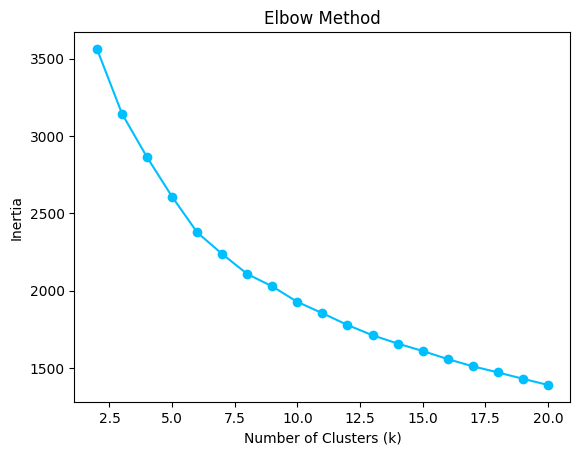

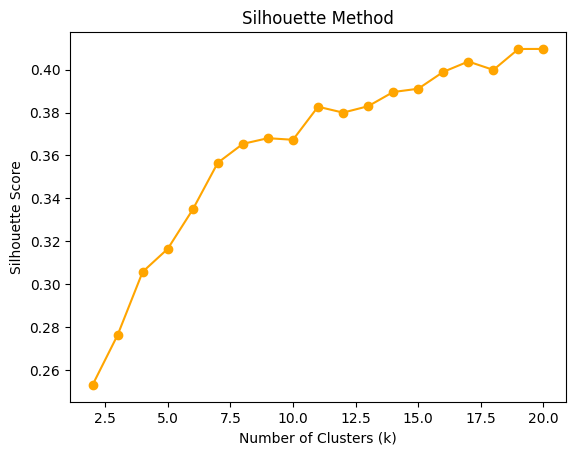

Optimal k by silhouette: 20
Creating visual vocabulary with k=20 from 7918 descriptors...
Visual vocabulary created successfully
Creating BOF histogram for: DM Group 2/DM096_M/DM096_M_R.csv
Created BOF histogram with 20 bins
Creating BOF histogram for: DM Group 2/DM096_M/DM096_M_L.csv
Created BOF histogram with 20 bins
Creating BOF histogram for: DM Group 2/DM052_F/DM052_F_R.csv
Created BOF histogram with 20 bins
Creating BOF histogram for: DM Group 2/DM052_F/DM052_F_L.csv
Created BOF histogram with 20 bins
Creating BOF histogram for: DM Group 2/DM116_F/DM116_F_R.csv
Created BOF histogram with 20 bins
Creating BOF histogram for: DM Group 2/DM116_F/DM116_F_L.csv
Created BOF histogram with 20 bins
Creating BOF histogram for: DM Group 2/DM058_F/DM058_F_R.csv
Created BOF histogram with 20 bins
Creating BOF histogram for: DM Group 2/DM058_F/DM058_F_L.csv
Created BOF histogram with 20 bins
Creating BOF histogram for: DM Group 2/DM010_M/DM010_M_R.csv
Created BOF histogram with 20 bins
Creatin

In [ ]:
!pip install scikit-learn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os
from sklearn.cluster import KMeans
import tempfile
# Import silhouette_score
from sklearn.metrics import silhouette_score

# SURF feature extraction code (reusing from previous implementation)
def compute_integral_image(image):
    """Compute the integral image representation."""
    integral = image.astype(np.float32)
    integral = np.cumsum(integral, axis=0)
    integral = np.cumsum(integral, axis=1)
    integral = np.pad(integral, ((1, 0), (1, 0)), mode='constant')
    return integral

def box_filter(integral_img, x, y, size):
    """Calculates the sum within a box region using the integral image."""
    half_size = size // 2
    x1 = max(1, x - half_size)
    y1 = max(1, y - half_size)
    x2 = min(integral_img.shape[0] - 1, x + half_size)
    y2 = min(integral_img.shape[1] - 1, y + half_size)

    A = integral_img[x1 - 1, y1 - 1]
    B = integral_img[x2, y1 - 1]
    C = integral_img[x1 - 1, y2]
    D = integral_img[x2, y2]
    return D - B - C + A

def hessian_response(integral_img, x, y, size):
    """Approximates the Hessian determinant response."""
    # Box filter approximations for 2nd order Gaussian derivatives
    Dxx = box_filter(integral_img, x, y, size)
    Dyy = box_filter(integral_img, x, y, size)
    Dxy = box_filter(integral_img, x, y, size)

    # Determinant of Hessian with balance factor 0.9
    return (Dxx * Dyy) - (0.9 * Dxy)**2

def detect_keypoints(integral_img, min_hessian=700, octaves=4, intervals=4):
    """Detects SURF keypoints using the Hessian matrix determinant."""
    keypoints = []

    for octave in range(octaves):
        for interval in range(intervals):
            # Upscale filter size instead of downscaling image
            size = 9 + (octave * intervals + interval) * 6

            # Step size increases with octave for efficiency
            step = 2 ** octave

            for x in range(size//2, integral_img.shape[0] - size//2 - 1, step):
                for y in range(size//2, integral_img.shape[1] - size//2 - 1, step):
                    response = hessian_response(integral_img, x, y, size)

                    if response > min_hessian:
                        # Non-maximal suppression
                        is_local_max = True
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                neighbor_x = x + dx * step
                                neighbor_y = y + dy * step

                                if (0 <= neighbor_x < integral_img.shape[0] and
                                    0 <= neighbor_y < integral_img.shape[1]):
                                    neighbor_response = hessian_response(integral_img, neighbor_x, neighbor_y, size)
                                    if neighbor_response > response:
                                        is_local_max = False
                                        break
                            if not is_local_max:
                                break

                        if is_local_max:
                            keypoints.append((x, y, size, response))

    return keypoints

def haar_wavelet_response(image, x, y, size, direction):
    """Compute Haar wavelet response in specified direction."""
    half_size = size // 2

    if direction == 'x':
        # Horizontal response
        left = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                     max(0, x-half_size):max(0, x)]
        right = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                      max(0, x):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on right, negative on left)
        left_sum = np.sum(left) if left.size > 0 else 0
        right_sum = np.sum(right) if right.size > 0 else 0

        # Normalize by area
        left_area = left.size
        right_area = right.size

        if left_area > 0 and right_area > 0:
            return (right_sum/right_area) - (left_sum/left_area)

    elif direction == 'y':
        # Vertical response
        top = image[max(0, y-half_size):max(0, y),
                    max(0, x-half_size):min(image.shape[1], x+half_size+1)]
        bottom = image[max(0, y):min(image.shape[0], y+half_size+1),
                       max(0, x-half_size):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on bottom, negative on top)
        top_sum = np.sum(top) if top.size > 0 else 0
        bottom_sum = np.sum(bottom) if bottom.size > 0 else 0

        # Normalize by area
        top_area = top.size
        bottom_area = bottom.size

        if top_area > 0 and bottom_area > 0:
            return (bottom_sum/bottom_area) - (top_sum/top_area)

    return 0

def calculate_orientation(image, keypoint):
    """Calculate orientation using circular region around keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Define circular region around keypoint with radius 6s
    radius = int(6 * scale)

    # Collect wavelet responses within circular region
    responses = []

    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            # Check if within circular region
            if dx*dx + dy*dy <= radius*radius:
                new_x = int(x + dx)
                new_y = int(y + dy)

                # Skip points outside image
                if not (0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0]):
                    continue

                # Calculate Haar wavelet responses at 2s scale
                wavelet_size = int(2 * scale)
                dx_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'x')
                dy_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'y')

                # Weight with Gaussian (σ = 2.5s)
                weight = np.exp(-(dx*dx + dy*dy) / (2 * (2.5 * scale)**2))
                dx_response *= weight
                dy_response *= weight

                responses.append((dx_response, dy_response))

    # Find dominant orientation
    orientation = 0
    max_sum = 0

    for angle in range(0, 360, 10):  # Check every 10 degrees
        sumx, sumy = 0, 0
        rad = np.radians(angle)

        # Calculate orientation window bounds (π/3 = 60 degrees)
        window_start = rad - np.pi/6
        window_end = rad + np.pi/6

        for dx_resp, dy_resp in responses:
            # Skip zero responses
            if dx_resp == 0 and dy_resp == 0:
                continue

            # Calculate angle of current response
            resp_angle = np.arctan2(dy_resp, dx_resp)

            # Normalize angle to [0, 2π]
            if resp_angle < 0:
                resp_angle += 2 * np.pi

            # Check if response is within current window
            in_window = False
            if window_start < 0:
                in_window = resp_angle <= window_end or resp_angle >= (2*np.pi + window_start)
            elif window_end > 2*np.pi:
                in_window = resp_angle >= window_start or resp_angle <= (window_end - 2*np.pi)
            else:
                in_window = window_start <= resp_angle <= window_end

            if in_window:
                sumx += dx_resp
                sumy += dy_resp

        # Calculate vector length
        sum_length = np.sqrt(sumx*sumx + sumy*sumy)

        if sum_length > max_sum:
            max_sum = sum_length
            orientation = angle

    return orientation

def create_descriptor(image, keypoint, orientation):
    """Create SURF descriptor for a keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Create a square region of size 20s around keypoint
    region_size = int(20 * scale)
    half_region = region_size // 2

    # Convert orientation to radians
    rad = np.radians(orientation)
    cos_t, sin_t = np.cos(rad), np.sin(rad)

    # Initialize descriptor
    descriptor = []

    # Divide region into 4×4 subregions
    for i in range(4):
        for j in range(4):
            # Subregion center in rotated coordinates
            sub_i = -half_region + (i + 0.5) * (region_size / 4)
            sub_j = -half_region + (j + 0.5) * (region_size / 4)

            # Initialize sums for this subregion
            sum_dx = 0
            sum_dy = 0
            sum_abs_dx = 0
            sum_abs_dy = 0

            # Compute 5×5 regularly spaced sample points
            for m in range(5):
                for n in range(5):
                    # Sample point in rotated coordinates
                    sample_i = sub_i - 2 * (region_size / 20) + m * (region_size / 20)
                    sample_j = sub_j - 2 * (region_size / 20) + n * (region_size / 20)

                    # Rotate sample point back to image coordinates
                    rot_i = cos_t * sample_i - sin_t * sample_j
                    rot_j = sin_t * sample_i + cos_t * sample_j

                    # Map to image coordinates
                    img_x = int(x + rot_j)
                    img_y = int(y + rot_i)

                    # Skip points outside image
                    if not (0 <= img_x < image.shape[1] and 0 <= img_y < image.shape[0]):
                        continue

                    # Compute Haar wavelet responses at 2s scale
                    wavelet_size = int(2 * scale)
                    dx = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'x')
                    dy = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'y')

                    # Rotate responses relative to keypoint orientation
                    rot_dx = cos_t * dx + sin_t * dy
                    rot_dy = -sin_t * dx + cos_t * dy

                    # Weight with Gaussian (σ = 3.3s)
                    weight = np.exp(-(sample_i*sample_i + sample_j*sample_j) / (2 * (3.3 * scale)**2))
                    rot_dx *= weight
                    rot_dy *= weight

                    # Accumulate responses
                    sum_dx += rot_dx
                    sum_dy += rot_dy
                    sum_abs_dx += abs(rot_dx)
                    sum_abs_dy += abs(rot_dy)

            # Add 4D vector to descriptor
            descriptor.extend([sum_dx, sum_dy, sum_abs_dx, sum_abs_dy])

    # Normalize descriptor
    descriptor = np.array(descriptor)
    norm = np.linalg.norm(descriptor)
    if norm > 0:
        descriptor /= norm

    return descriptor

def extract_surf_features(image, min_hessian=1000):
    """Extract SURF features from an image."""
    # Compute integral image
    integral_img = compute_integral_image(image)

    # Detect keypoints
    keypoints = detect_keypoints(integral_img, min_hessian)
    print(f"Detected {len(keypoints)} keypoints")

    # Extract descriptors
    descriptors = []
    oriented_keypoints = []

    for keypoint in keypoints:
        # Assign orientation
        orientation = calculate_orientation(image, keypoint)

        # Create descriptor
        descriptor = create_descriptor(image, keypoint, orientation)

        descriptors.append(descriptor)
        oriented_keypoints.append((*keypoint, orientation))

    return oriented_keypoints, np.array(descriptors)

# BOF implementation as per screenshots
def create_visual_vocabulary(all_descriptors, k=50):
    """
    Create a visual vocabulary by clustering descriptors.

    Args:
        all_descriptors: Combined descriptors from all images
        k: Number of clusters (visual words)

    Returns:
        KMeans model containing the vocabulary
    """
    print(f"Creating visual vocabulary with k={k} from {len(all_descriptors)} descriptors...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)
    print("Visual vocabulary created successfully")
    return kmeans

def create_bof_histogram(descriptors, kmeans_model):
    """
    Create a Bag of Features histogram for the given descriptors.

    Args:
        descriptors: Array of descriptors from an image
        kmeans_model: Trained KMeans model (vocabulary)

    Returns:
        BOF histogram (frequency of visual words)
    """
    if len(descriptors) == 0:
        return np.zeros(kmeans_model.n_clusters)

    # Assign each descriptor to a cluster (visual word)
    visual_words = kmeans_model.predict(descriptors)

    # Create histogram of visual word occurrences
    histogram, _ = np.histogram(visual_words, bins=np.arange(kmeans_model.n_clusters+1), density=True)

    return histogram




# Function to process multiple CSV files from a zip archive
def process_zip_files(zip_path, output_excel, min_hessian=500):
    if not os.path.exists(zip_path):
        print(f"Zip file not found: {zip_path}")
        return

    temp_dir = tempfile.mkdtemp()
    try:
        all_descriptors = []
        file_descriptors = {}

        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
            print(f"Found {len(csv_files)} CSV files in the zip archive")

            for csv_file in csv_files:
                print(f"Extracting features from: {csv_file}")
                try:
                    zip_file.extract(csv_file, temp_dir)
                    file_path = os.path.join(temp_dir, csv_file)
                    data = pd.read_csv(file_path, header=None)
                    temperature_data = data.to_numpy()
                    normalized_data = ((temperature_data - np.min(temperature_data)) /
                                      (np.max(temperature_data) - np.min(temperature_data)) * 255).astype(np.uint8)
                    _, descriptors = extract_surf_features(normalized_data, min_hessian)
                    if len(descriptors) > 0:
                        all_descriptors.append(descriptors)
                        file_descriptors[csv_file] = descriptors
                        print(f"Extracted {len(descriptors)} descriptors from {csv_file}")
                    else:
                        print(f"No descriptors found in {csv_file}")
                except Exception as e:
                    print(f"Error processing {csv_file}: {str(e)}")

        if not all_descriptors:
            print("No descriptors found in any file. Exiting.")
            return

        combined_descriptors = np.vstack(all_descriptors)
        print(f"Total {len(combined_descriptors)} descriptors for vocabulary creation")

        # --- Find optimal k using Silhouette and Elbow methods ---
        k_range = range(2, 21)
        inertia = []
        silhouette_scores = []

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(combined_descriptors)
            inertia.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(combined_descriptors, labels))

        # Plot Elbow
        plt.figure()
        plt.plot(k_range, inertia, marker='o', color='deepskyblue')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.title('Elbow Method')
        plt.show()

        # Plot Silhouette
        plt.figure()
        plt.plot(k_range, silhouette_scores, marker='o', color='orange')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Method')
        plt.show()

        # Choose k with the highest silhouette score
        optimal_k = k_range[np.argmax(silhouette_scores)]
        print(f"Optimal k by silhouette: {optimal_k}")

        # --- Use optimal_k for the rest of the pipeline ---
        kmeans_model = create_visual_vocabulary(combined_descriptors, optimal_k)

        results = []
        for csv_file, descriptors in file_descriptors.items():
            print(f"Creating BOF histogram for: {csv_file}")
            histogram = create_bof_histogram(descriptors, kmeans_model)
            result = {"Filename": os.path.basename(csv_file)}
            for i, value in enumerate(histogram):
                result[f"Descriptor_{i+1}"] = value
            results.append(result)
            print(f"Created BOF histogram with {len(histogram)} bins")

        if results:
            df_results = pd.DataFrame(results)
            df_results.to_excel(output_excel, index=False)
            print(f"Results saved to {output_excel}")
        else:
            print("No results to save")

    finally:
        import shutil
        shutil.rmtree(temp_dir)

def main():
    zip_path = '/content/DM Group LR.zip'  # Update this to your actual zip file path
    output_excel = 'SURF_FULLFOOT_OPTIMAL_K.xlsx'
    process_zip_files(zip_path, output_excel, min_hessian=500)

if __name__ == '__main__':
    main()

control group


Found 180 CSV files in the zip archive
Extracting features from: Control Group 2/CG029_F/CG029_F_L.csv
Detected 12 keypoints
Extracted 12 descriptors from Control Group 2/CG029_F/CG029_F_L.csv
Extracting features from: __MACOSX/Control Group 2/CG029_F/._CG029_F_L.csv
Error processing __MACOSX/Control Group 2/CG029_F/._CG029_F_L.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: Control Group 2/CG029_F/CG029_F_R.csv
Detected 18 keypoints
Extracted 18 descriptors from Control Group 2/CG029_F/CG029_F_R.csv
Extracting features from: __MACOSX/Control Group 2/CG029_F/._CG029_F_R.csv
Error processing __MACOSX/Control Group 2/CG029_F/._CG029_F_R.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: Control Group 2/CG042_F/CG042_F_L.csv
Detected 30 keypoints
Extracted 30 descriptors from Control Group 2/CG042_F/CG042_F_L.csv
Extracting features from: __MACOSX/Control Group 2/CG042_F/._CG042_F_L.

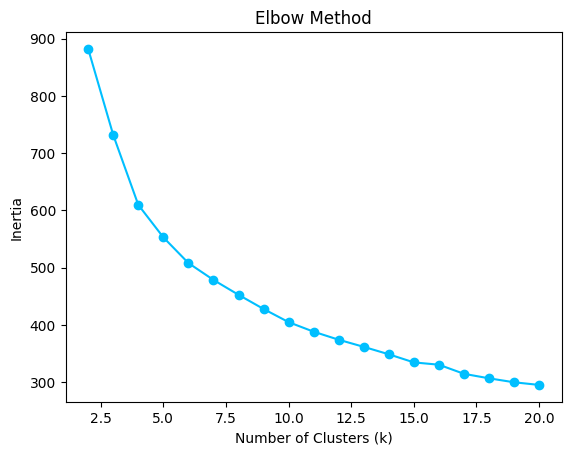

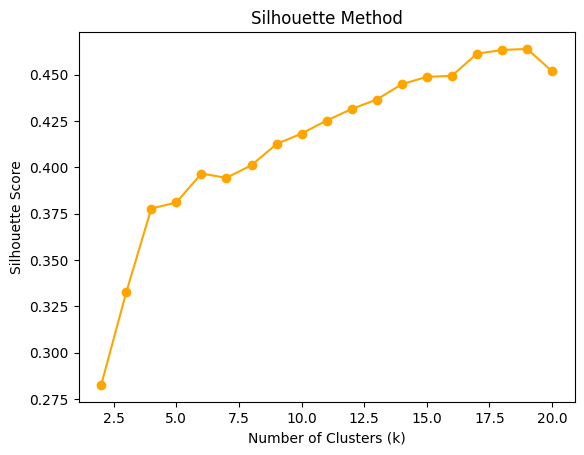

Optimal k by silhouette: 19
Creating visual vocabulary with k=19 from 2034 descriptors...
Visual vocabulary created successfully
Creating BOF histogram for: Control Group 2/CG029_F/CG029_F_L.csv
Created BOF histogram with 19 bins
Creating BOF histogram for: Control Group 2/CG029_F/CG029_F_R.csv
Created BOF histogram with 19 bins
Creating BOF histogram for: Control Group 2/CG042_F/CG042_F_L.csv
Created BOF histogram with 19 bins
Creating BOF histogram for: Control Group 2/CG042_F/CG042_F_R.csv
Created BOF histogram with 19 bins
Creating BOF histogram for: Control Group 2/CG023_F/CG023_F_L.csv
Created BOF histogram with 19 bins
Creating BOF histogram for: Control Group 2/CG023_F/CG023_F_R.csv
Created BOF histogram with 19 bins
Creating BOF histogram for: Control Group 2/CG025_M/CG025_M_L.csv
Created BOF histogram with 19 bins
Creating BOF histogram for: Control Group 2/CG025_M/CG025_M_R.csv
Created BOF histogram with 19 bins
Creating BOF histogram for: Control Group 2/CG006_F/CG006_F_L.c

In [ ]:
!pip install scikit-learn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os
from sklearn.cluster import KMeans
import tempfile
# Import silhouette_score
from sklearn.metrics import silhouette_score

# SURF feature extraction code (reusing from previous implementation)
def compute_integral_image(image):
    """Compute the integral image representation."""
    integral = image.astype(np.float32)
    integral = np.cumsum(integral, axis=0)
    integral = np.cumsum(integral, axis=1)
    integral = np.pad(integral, ((1, 0), (1, 0)), mode='constant')
    return integral

def box_filter(integral_img, x, y, size):
    """Calculates the sum within a box region using the integral image."""
    half_size = size // 2
    x1 = max(1, x - half_size)
    y1 = max(1, y - half_size)
    x2 = min(integral_img.shape[0] - 1, x + half_size)
    y2 = min(integral_img.shape[1] - 1, y + half_size)

    A = integral_img[x1 - 1, y1 - 1]
    B = integral_img[x2, y1 - 1]
    C = integral_img[x1 - 1, y2]
    D = integral_img[x2, y2]
    return D - B - C + A

def hessian_response(integral_img, x, y, size):
    """Approximates the Hessian determinant response."""
    # Box filter approximations for 2nd order Gaussian derivatives
    Dxx = box_filter(integral_img, x, y, size)
    Dyy = box_filter(integral_img, x, y, size)
    Dxy = box_filter(integral_img, x, y, size)

    # Determinant of Hessian with balance factor 0.9
    return (Dxx * Dyy) - (0.9 * Dxy)**2

def detect_keypoints(integral_img, min_hessian=700, octaves=4, intervals=4):
    """Detects SURF keypoints using the Hessian matrix determinant."""
    keypoints = []

    for octave in range(octaves):
        for interval in range(intervals):
            # Upscale filter size instead of downscaling image
            size = 9 + (octave * intervals + interval) * 6

            # Step size increases with octave for efficiency
            step = 2 ** octave

            for x in range(size//2, integral_img.shape[0] - size//2 - 1, step):
                for y in range(size//2, integral_img.shape[1] - size//2 - 1, step):
                    response = hessian_response(integral_img, x, y, size)

                    if response > min_hessian:
                        # Non-maximal suppression
                        is_local_max = True
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                neighbor_x = x + dx * step
                                neighbor_y = y + dy * step

                                if (0 <= neighbor_x < integral_img.shape[0] and
                                    0 <= neighbor_y < integral_img.shape[1]):
                                    neighbor_response = hessian_response(integral_img, neighbor_x, neighbor_y, size)
                                    if neighbor_response > response:
                                        is_local_max = False
                                        break
                            if not is_local_max:
                                break

                        if is_local_max:
                            keypoints.append((x, y, size, response))

    return keypoints

def haar_wavelet_response(image, x, y, size, direction):
    """Compute Haar wavelet response in specified direction."""
    half_size = size // 2

    if direction == 'x':
        # Horizontal response
        left = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                     max(0, x-half_size):max(0, x)]
        right = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                      max(0, x):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on right, negative on left)
        left_sum = np.sum(left) if left.size > 0 else 0
        right_sum = np.sum(right) if right.size > 0 else 0

        # Normalize by area
        left_area = left.size
        right_area = right.size

        if left_area > 0 and right_area > 0:
            return (right_sum/right_area) - (left_sum/left_area)

    elif direction == 'y':
        # Vertical response
        top = image[max(0, y-half_size):max(0, y),
                    max(0, x-half_size):min(image.shape[1], x+half_size+1)]
        bottom = image[max(0, y):min(image.shape[0], y+half_size+1),
                       max(0, x-half_size):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on bottom, negative on top)
        top_sum = np.sum(top) if top.size > 0 else 0
        bottom_sum = np.sum(bottom) if bottom.size > 0 else 0

        # Normalize by area
        top_area = top.size
        bottom_area = bottom.size

        if top_area > 0 and bottom_area > 0:
            return (bottom_sum/bottom_area) - (top_sum/top_area)

    return 0

def calculate_orientation(image, keypoint):
    """Calculate orientation using circular region around keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Define circular region around keypoint with radius 6s
    radius = int(6 * scale)

    # Collect wavelet responses within circular region
    responses = []

    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            # Check if within circular region
            if dx*dx + dy*dy <= radius*radius:
                new_x = int(x + dx)
                new_y = int(y + dy)

                # Skip points outside image
                if not (0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0]):
                    continue

                # Calculate Haar wavelet responses at 2s scale
                wavelet_size = int(2 * scale)
                dx_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'x')
                dy_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'y')

                # Weight with Gaussian (σ = 2.5s)
                weight = np.exp(-(dx*dx + dy*dy) / (2 * (2.5 * scale)**2))
                dx_response *= weight
                dy_response *= weight

                responses.append((dx_response, dy_response))

    # Find dominant orientation
    orientation = 0
    max_sum = 0

    for angle in range(0, 360, 10):  # Check every 10 degrees
        sumx, sumy = 0, 0
        rad = np.radians(angle)

        # Calculate orientation window bounds (π/3 = 60 degrees)
        window_start = rad - np.pi/6
        window_end = rad + np.pi/6

        for dx_resp, dy_resp in responses:
            # Skip zero responses
            if dx_resp == 0 and dy_resp == 0:
                continue

            # Calculate angle of current response
            resp_angle = np.arctan2(dy_resp, dx_resp)

            # Normalize angle to [0, 2π]
            if resp_angle < 0:
                resp_angle += 2 * np.pi

            # Check if response is within current window
            in_window = False
            if window_start < 0:
                in_window = resp_angle <= window_end or resp_angle >= (2*np.pi + window_start)
            elif window_end > 2*np.pi:
                in_window = resp_angle >= window_start or resp_angle <= (window_end - 2*np.pi)
            else:
                in_window = window_start <= resp_angle <= window_end

            if in_window:
                sumx += dx_resp
                sumy += dy_resp

        # Calculate vector length
        sum_length = np.sqrt(sumx*sumx + sumy*sumy)

        if sum_length > max_sum:
            max_sum = sum_length
            orientation = angle

    return orientation

def create_descriptor(image, keypoint, orientation):
    """Create SURF descriptor for a keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Create a square region of size 20s around keypoint
    region_size = int(20 * scale)
    half_region = region_size // 2

    # Convert orientation to radians
    rad = np.radians(orientation)
    cos_t, sin_t = np.cos(rad), np.sin(rad)

    # Initialize descriptor
    descriptor = []

    # Divide region into 4×4 subregions
    for i in range(4):
        for j in range(4):
            # Subregion center in rotated coordinates
            sub_i = -half_region + (i + 0.5) * (region_size / 4)
            sub_j = -half_region + (j + 0.5) * (region_size / 4)

            # Initialize sums for this subregion
            sum_dx = 0
            sum_dy = 0
            sum_abs_dx = 0
            sum_abs_dy = 0

            # Compute 5×5 regularly spaced sample points
            for m in range(5):
                for n in range(5):
                    # Sample point in rotated coordinates
                    sample_i = sub_i - 2 * (region_size / 20) + m * (region_size / 20)
                    sample_j = sub_j - 2 * (region_size / 20) + n * (region_size / 20)

                    # Rotate sample point back to image coordinates
                    rot_i = cos_t * sample_i - sin_t * sample_j
                    rot_j = sin_t * sample_i + cos_t * sample_j

                    # Map to image coordinates
                    img_x = int(x + rot_j)
                    img_y = int(y + rot_i)

                    # Skip points outside image
                    if not (0 <= img_x < image.shape[1] and 0 <= img_y < image.shape[0]):
                        continue

                    # Compute Haar wavelet responses at 2s scale
                    wavelet_size = int(2 * scale)
                    dx = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'x')
                    dy = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'y')

                    # Rotate responses relative to keypoint orientation
                    rot_dx = cos_t * dx + sin_t * dy
                    rot_dy = -sin_t * dx + cos_t * dy

                    # Weight with Gaussian (σ = 3.3s)
                    weight = np.exp(-(sample_i*sample_i + sample_j*sample_j) / (2 * (3.3 * scale)**2))
                    rot_dx *= weight
                    rot_dy *= weight

                    # Accumulate responses
                    sum_dx += rot_dx
                    sum_dy += rot_dy
                    sum_abs_dx += abs(rot_dx)
                    sum_abs_dy += abs(rot_dy)

            # Add 4D vector to descriptor
            descriptor.extend([sum_dx, sum_dy, sum_abs_dx, sum_abs_dy])

    # Normalize descriptor
    descriptor = np.array(descriptor)
    norm = np.linalg.norm(descriptor)
    if norm > 0:
        descriptor /= norm

    return descriptor

def extract_surf_features(image, min_hessian=1000):
    """Extract SURF features from an image."""
    # Compute integral image
    integral_img = compute_integral_image(image)

    # Detect keypoints
    keypoints = detect_keypoints(integral_img, min_hessian)
    print(f"Detected {len(keypoints)} keypoints")

    # Extract descriptors
    descriptors = []
    oriented_keypoints = []

    for keypoint in keypoints:
        # Assign orientation
        orientation = calculate_orientation(image, keypoint)

        # Create descriptor
        descriptor = create_descriptor(image, keypoint, orientation)

        descriptors.append(descriptor)
        oriented_keypoints.append((*keypoint, orientation))

    return oriented_keypoints, np.array(descriptors)

# BOF implementation as per screenshots
def create_visual_vocabulary(all_descriptors, k=50):
    """
    Create a visual vocabulary by clustering descriptors.

    Args:
        all_descriptors: Combined descriptors from all images
        k: Number of clusters (visual words)

    Returns:
        KMeans model containing the vocabulary
    """
    print(f"Creating visual vocabulary with k={k} from {len(all_descriptors)} descriptors...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)
    print("Visual vocabulary created successfully")
    return kmeans

def create_bof_histogram(descriptors, kmeans_model):
    """
    Create a Bag of Features histogram for the given descriptors.

    Args:
        descriptors: Array of descriptors from an image
        kmeans_model: Trained KMeans model (vocabulary)

    Returns:
        BOF histogram (frequency of visual words)
    """
    if len(descriptors) == 0:
        return np.zeros(kmeans_model.n_clusters)

    # Assign each descriptor to a cluster (visual word)
    visual_words = kmeans_model.predict(descriptors)

    # Create histogram of visual word occurrences
    histogram, _ = np.histogram(visual_words, bins=np.arange(kmeans_model.n_clusters+1), density=True)

    return histogram




# Function to process multiple CSV files from a zip archive
def process_zip_files(zip_path, output_excel, min_hessian=500):
    if not os.path.exists(zip_path):
        print(f"Zip file not found: {zip_path}")
        return

    temp_dir = tempfile.mkdtemp()
    try:
        all_descriptors = []
        file_descriptors = {}

        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
            print(f"Found {len(csv_files)} CSV files in the zip archive")

            for csv_file in csv_files:
                print(f"Extracting features from: {csv_file}")
                try:
                    zip_file.extract(csv_file, temp_dir)
                    file_path = os.path.join(temp_dir, csv_file)
                    data = pd.read_csv(file_path, header=None)
                    temperature_data = data.to_numpy()
                    normalized_data = ((temperature_data - np.min(temperature_data)) /
                                      (np.max(temperature_data) - np.min(temperature_data)) * 255).astype(np.uint8)
                    _, descriptors = extract_surf_features(normalized_data, min_hessian)
                    if len(descriptors) > 0:
                        all_descriptors.append(descriptors)
                        file_descriptors[csv_file] = descriptors
                        print(f"Extracted {len(descriptors)} descriptors from {csv_file}")
                    else:
                        print(f"No descriptors found in {csv_file}")
                except Exception as e:
                    print(f"Error processing {csv_file}: {str(e)}")

        if not all_descriptors:
            print("No descriptors found in any file. Exiting.")
            return

        combined_descriptors = np.vstack(all_descriptors)
        print(f"Total {len(combined_descriptors)} descriptors for vocabulary creation")

        # --- Find optimal k using Silhouette and Elbow methods ---
        k_range = range(2, 21)
        inertia = []
        silhouette_scores = []

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(combined_descriptors)
            inertia.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(combined_descriptors, labels))

        # Plot Elbow
        plt.figure()
        plt.plot(k_range, inertia, marker='o', color='deepskyblue')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.title('Elbow Method')
        plt.show()

        # Plot Silhouette
        plt.figure()
        plt.plot(k_range, silhouette_scores, marker='o', color='orange')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Method')
        plt.show()

        # Choose k with the highest silhouette score
        optimal_k = k_range[np.argmax(silhouette_scores)]
        print(f"Optimal k by silhouette: {optimal_k}")

        # --- Use optimal_k for the rest of the pipeline ---
        kmeans_model = create_visual_vocabulary(combined_descriptors, optimal_k)

        results = []
        for csv_file, descriptors in file_descriptors.items():
            print(f"Creating BOF histogram for: {csv_file}")
            histogram = create_bof_histogram(descriptors, kmeans_model)
            result = {"Filename": os.path.basename(csv_file)}
            for i, value in enumerate(histogram):
                result[f"Descriptor_{i+1}"] = value
            results.append(result)
            print(f"Created BOF histogram with {len(histogram)} bins")

        if results:
            df_results = pd.DataFrame(results)
            df_results.to_excel(output_excel, index=False)
            print(f"Results saved to {output_excel}")
        else:
            print("No results to save")

    finally:
        import shutil
        shutil.rmtree(temp_dir)

def main():
    zip_path = '/content/Control Group LR.zip'  # Update this to your actual zip file path
    output_excel = 'SURF_FULLFOOT_OPTIMAL_K_cg.xlsx'
    process_zip_files(zip_path, output_excel, min_hessian=500)

if __name__ == '__main__':
    main()

Smote

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

def balance_dataset(file1, file2, output_file):
    """
    Balances the smaller dataset using SMOTE to match the larger dataset.

    Args:
        file1 (str): Path to the CSV file with 450 samples.
        file2 (str): Path to the CSV file with 1220 samples.
        output_file (str): Path to save the balanced dataset.
    """
    # Load both datasets using pd.read_csv
    df1 = pd.read_excel(file1)
    df2 = pd.read_excel(file2)

    # Concatenate both datasets for SMOTE processing
    df1['label'] = 0  # Assign label 0 for file1
    df2['label'] = 1  # Assign label 1 for file2

    combined_df = pd.concat([df1, df2], ignore_index=True)

    # Separate features and labels
    X = combined_df.iloc[:, 1:-1].values  # All descriptor columns (exclude filename and label)
    y = combined_df['label'].values      # Label column

    # Apply SMOTE to balance the data
    #The sampling_strategy parameter is modified to oversample the minority class (label 0)
    #to match the number of samples in the majority class (label 1).
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Create a new DataFrame for the balanced dataset
    balanced_df = pd.DataFrame(X_resampled, columns=combined_df.columns[1:-1])
    balanced_df['label'] = y_resampled

    # Save the balanced dataset to an Excel file
    balanced_df.to_excel(output_file, index=False)
    print(f"Balanced dataset saved as {output_file}")

# Example usage
file1_path = '/content/SURF_FULLFOOT_OPTIMAL_K.xlsx'   # File with 450 samples
file2_path = '/content/SURF_FULLFOOT_OPTIMAL_K.xlsx' # File with 1220 samples
output_path = '/content/balanced_dataset_surf_k=20_fullfoot.xlsx'             # Output file path

balance_dataset(file1_path, file2_path, output_path)

Balanced dataset saved as /content/balanced_dataset_surf_k=20_fullfoot.xlsx
